<a href="https://colab.research.google.com/github/rodolfomssouza/Notebooks/blob/master/Soil_water_balance_crop_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling water balance


The soil water balance at the daily time scale can be modeled as

$$n Z_r \dfrac{ds}{dt} = R - C_I - Q - L - E - T$$

where $n Z_r$ is the water storage capacity, $R$ is the rain, $C_I$ is the canopy interception, $Q$ is the runoff, $L$ is the deep drainage (leakage), $E$ is the soil evaporation, and $T$ is the plant transpiration.

In crop systems, the plant stage also impacts on the canopy interceptation, transpiration, and evaporation.
Thus, the crop cover fraction will be consideted to compute the $C_I$, $E$, and $T$.


## Packages

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Water balance components

In [2]:
def poisson_process(n, lbd, alpha):
    """
    Creates rainfall series based on Poisson process.

    Parameters
    ----------
    n: array_like
       The number of events
    lbd: array_like 
       The rain events mean distribution 
    alpha: array_like
       Mean rain depth

    Returns
    -------
    samples: ndarray
       n Rain events in the same unit of alpha.
    """
    rain = np.zeros(n)
    for i in np.arange(n):
        n1 = np.random.uniform(0, 1, 1)
        if n1 < lbd:
            n2 = np.random.uniform(0, 1, 1)
            rain[i] = -alpha * np.log((1 - n2))
        else:
            rain[i] = 0
    return rain


def canopyI(r, rth):
    # Computes the canopy interception
    if r <= rth:
        ci = r
    else:
        ci = rth
    return ci


def leakage(s, ks, beta):
    lk = ks * s**beta
    return lk


# Transpiration
def transpiration(s, sw, sstar, ct, eto):
    # Compute soil moisture factor
    if s <= sw:
        fs = 0
    elif sw <= s <= sstar:
        fs = (s - sw) / (sstar - sw)
    else:
        fs = 1
    # Compute transpiration
    tp = fs * ct * eto
    return tp


def evaporation(s, sh, ce, eto):
    # Compute soil moisture factor
    if s <= sh:
        fs = 0
    else:
        fs = (s - sh) / (1 - sh)
    ev = fs * ce * eto
    return ev


def cover(c, cmax, eto, r, t, tsen, gamma):
    if (t - tsen) < 0:
        hvs = 0
    else:
        hvs = 1
    # eto = eto / 100
    dtc = r * eto * c * (1 - c / cmax) - (gamma * (t - tsen) * hvs) * c ** 2
    return dtc


## Numerical solution

In [3]:
# Solving soil water balance and crop fraction cover
def swbcrop(rain, eto, c, s, sh, sw, sstar, ks, beta, n, zr, rth,
            ce, ct, gamma, r, cmax, tsen, dt):
    # Computes the soil water balance without mulching
    nr = len(rain)
    sres = np.zeros(nr, dtype=float)
    cires = np.zeros(nr, dtype=float)
    qres = np.zeros(nr, dtype=float)
    tres = np.zeros(nr, dtype=float)
    tres_ns = np.zeros(nr, dtype=float)
    eres = np.zeros(nr, dtype=float)
    lres = np.zeros(nr, dtype=float)
    cover_res = np.zeros(nr, dtype=float)

    dc = np.zeros(nr, dtype=float)
    cdt = 1
    gamma = gamma * dt

    nzr = n * zr
    # Computing the soil water balance
    for i in range(nr):
        dc[i] = cdt
        cdt += dt

        cires[i] = canopyI(rain[i], (rth * dt)) * c 
        th = rain[i] - cires[i]
        s = s + th / nzr
        if s > 1:
            qres[i] = (s - 1) * nzr
            s = 1
        else:
            qres[i] = 0
            pass
        tres[i] = transpiration(s, sw, sstar, ct, eto) * c * dt

        # Compute Transpiration under non stressed condition
        if s >= sstar:
            tres_ns[i] = tres[i]
            pass
        s = s - (tres[i] / nzr)

        # Evaporation
        eres[i] = evaporation(s, sh, ce, eto) * (1 - c) * dt
        s = s - (eres[i] / nzr)

        # Leakage
        lres[i] = leakage(s, ks, beta) * dt
        s = s - (lres[i] / nzr)
        sres[i] = s

        # Cover
        cover_res[i] = c + cover(c, cmax, tres[i], r, dc[i], tsen, gamma)
        c = cover_res[i]

    # Create dataframe to export results
    nr = int(len(rain) * dt)
    days = np.arange(nr)
    days = np.arange(nr)
    days = days + 1
    days = np.repeat(days, int(1 / dt))
    df = {'Days': days, 'DaysC': dc, 'Rain': rain, 'CI': cires, 'Q': qres,
          's': sres, 'Lk': lres, 'E': eres, 'T': tres, 'Tns': tres_ns,
          'Cover': cover_res}
    df = pd.DataFrame(df)
    return df


def dttoday(df, dt):
    sol = df.pivot_table(values=['Rain', 'CI', 'Q', 's', 'Lk', 'E', 'T', 'Tns',
                                 'Cover'], index='Days',
                         aggfunc={'Rain': np.sum, 'CI': np.sum,
                                  'Q': np.sum, 's': np.mean,
                                  'Lk': np.sum, 'E': np.sum,
                                  'T': np.sum, 'Tns': np.sum,
                                  'Cover': 'last'})
    sol['Days'] = sol.index
    return sol


## Parameters and simulation

In [10]:
# Time step and crop length season
dt = 1 / 48
days = 120

# Parameters
p = {'sh': 0.15,
     'sw': 0.25,
     'sstar': 0.55,
     'ks': 160,
     'beta': 16.0,
     'n': 0.50,
     'zr': 40,
     'rth': 0.20,
     'ce': 1.0,
     'ct': 1.0,
     'c': 0.1,
     'eto': 0.50,
     'gamma': 0.005,
     'r': 0.50,
     'cmax': 0.95,
     'tsen': 90,
     'dt': dt}

lbd = 0.3 * dt
alpha = 0.75

# Generate rainfall series
rain = poisson_process(int(days * 1/dt), lbd, alpha)

# Run the simulation
sol = swbcrop(rain=rain, s=0.5, **p)
sol_daily = dttoday(sol, dt)

## Figures

Text(0, 0.5, 'Leakage (cm day$^{-1}$)')

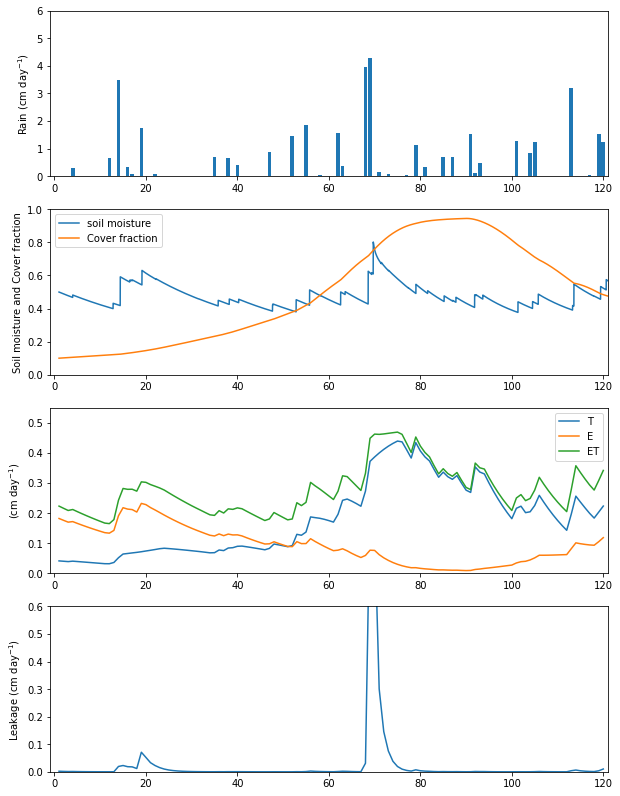

In [11]:
fig = plt.figure(figsize=(10, 14))

# Rain and canopy interception
ax1 = fig.add_subplot(411)
ax1.bar(sol_daily['Days'], sol_daily['Rain'], label='Rain')
ax1.set_ylabel('Rain (cm day$^{-1}$)')
ax1.set_xlim([-1, 121])
ax1.set_ylim([0, 6])

# Soil moisture and cover fraction
ax2 = fig.add_subplot(412)
ax2.plot(sol['DaysC'], sol['s'], label='soil moisture')
ax2.plot(sol['DaysC'], sol['Cover'], label='Cover fraction')
ax2.set_xlim([-1, 121])
ax2.set_ylim([0, 1])
ax2.legend()
ax2.set_ylabel('Soil moisture and Cover fraction')

# EvapoTranspiration
ax3 = fig.add_subplot(413)
ax3.plot(sol_daily['Days'], sol_daily['T'], label='T')
ax3.plot(sol_daily['Days'], sol_daily['E'], label='E')
ax3.plot(sol_daily['Days'], (sol_daily['T'] + sol_daily['E']), label='ET')
ax3.set_xlim([-1, 121])
ax3.set_ylim([0, 0.55])
ax3.set_ylabel('(cm day$^{-1}$)')
ax3.legend()

# Leakage
ax4 = fig.add_subplot(414)
ax4.plot(sol_daily['Days'], sol_daily['Lk'])
ax4.set_xlim([-1, 121])
ax4.set_ylim([0, 0.6])
ax4.set_ylabel('Leakage (cm day$^{-1}$)')